# 05 - Sentiment Analysis and Response Generation

This notebook implements advanced sentiment analysis and LLaMA-powered response generation.
It uses the classification and ETA results from previous notebooks to generate contextual responses.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=== Sentiment Analysis & Response Generation ===")
print("LLaMA-powered sentiment analysis and personalized response generation")
print()

=== Sentiment Analysis & Response Generation ===
LLaMA-powered sentiment analysis and personalized response generation



In [2]:
# Load previous results and configuration
def load_previous_results():
    """Load ETA predictions and model configuration"""
    
    # Load ETA predictions
    eta_path = Path("../outputs/eta_predictions.csv")
    if eta_path.exists():
        eta_df = pd.read_csv(eta_path)
        print(f"✅ Loaded {len(eta_df)} tickets with ETA predictions")
    else:
        raise FileNotFoundError("ETA predictions not found. Please run notebook 04 first.")
    
    # Load model configuration
    config_path = Path("../outputs/customer_support_model_config.json")
    if config_path.exists():
        with open(config_path, 'r') as f:
            config = json.load(f)
        print("✅ Model configuration loaded")
    else:
        raise FileNotFoundError("Model configuration not found. Please run notebook 02 first.")
    
    # Load LLaMA setup config
    llama_config_path = Path("../outputs/llama_setup_config.json")
    if llama_config_path.exists():
        with open(llama_config_path, 'r') as f:
            llama_config = json.load(f)
        print("✅ LLaMA setup configuration loaded")
    else:
        raise FileNotFoundError("LLaMA configuration not found. Please run LLAMA_SETUP.ipynb first.")
    
    return eta_df, config, llama_config

eta_results, model_config, llama_config = load_previous_results()
print(f"\nReady to process {len(eta_results)} tickets for sentiment analysis and response generation")

✅ Loaded 20 tickets with ETA predictions
✅ Model configuration loaded
✅ LLaMA setup configuration loaded

Ready to process 20 tickets for sentiment analysis and response generation


In [3]:
# Enhanced Sentiment Analysis System
class AdvancedSentimentAnalyzer:
    def __init__(self):
        # Enhanced sentiment indicators
        self.sentiment_patterns = {
            'very_positive': {
                'words': ['amazing', 'excellent', 'outstanding', 'fantastic', 'perfect', 'love'],
                'phrases': ['thank you so much', 'really appreciate', 'exceeded expectations'],
                'score': 2.0
            },
            'positive': {
                'words': ['good', 'great', 'nice', 'helpful', 'thanks', 'satisfied'],
                'phrases': ['thank you', 'well done', 'good job'],
                'score': 1.0
            },
            'neutral': {
                'words': ['okay', 'fine', 'acceptable', 'standard'],
                'phrases': ['how to', 'can you', 'please help'],
                'score': 0.0
            },
            'negative': {
                'words': ['bad', 'poor', 'disappointed', 'frustrated', 'annoyed', 'problem'],
                'phrases': ['not working', 'not satisfied', 'having issues'],
                'score': -1.0
            },
            'very_negative': {
                'words': ['terrible', 'awful', 'horrible', 'worst', 'hate', 'furious'],
                'phrases': ['completely unacceptable', 'want my money back', 'never again'],
                'score': -2.0
            }
        }
    
    def analyze_sentiment_detailed(self, text):
        """Perform detailed sentiment analysis"""
        text_lower = text.lower()
        sentiment_score = 0.0
        matched_patterns = []
        
        # Check each sentiment category
        for sentiment_type, patterns in self.sentiment_patterns.items():
            # Check words
            word_matches = sum(1 for word in patterns['words'] if word in text_lower)
            
            # Check phrases
            phrase_matches = sum(1 for phrase in patterns['phrases'] if phrase in text_lower)
            
            # Calculate contribution
            total_matches = word_matches + phrase_matches * 2  # Phrases count double
            if total_matches > 0:
                sentiment_score += patterns['score'] * total_matches
                matched_patterns.append({
                    'type': sentiment_type,
                    'matches': total_matches,
                    'contribution': patterns['score'] * total_matches
                })
        
        # Determine final sentiment
        if sentiment_score >= 2.0:
            final_sentiment = 'very_positive'
        elif sentiment_score >= 0.5:
            final_sentiment = 'positive'
        elif sentiment_score <= -2.0:
            final_sentiment = 'very_negative'
        elif sentiment_score <= -0.5:
            final_sentiment = 'negative'
        else:
            final_sentiment = 'neutral'
        
        return {
            'sentiment': final_sentiment,
            'confidence_score': abs(sentiment_score),
            'raw_score': sentiment_score,
            'matched_patterns': matched_patterns
        }

print("Initializing advanced sentiment analyzer...")
sentiment_analyzer = AdvancedSentimentAnalyzer()
print("✅ Sentiment analyzer ready")

Initializing advanced sentiment analyzer...
✅ Sentiment analyzer ready


In [4]:
# LLaMA Response Generator
class LLaMAResponseGenerator:
    def __init__(self, llama_config):
        self.llama_config = llama_config
        self.model_name = llama_config['model_name']
        self.device = llama_config['system_specs']['device']
        self.model = None
        self.tokenizer = None
        
        # Response templates based on sentiment and category
        self.response_templates = {
            'very_positive': {
                'greeting': "Thank you so much for your wonderful feedback!",
                'tone': 'enthusiastic'
            },
            'positive': {
                'greeting': "Thank you for contacting us!",
                'tone': 'friendly'
            },
            'neutral': {
                'greeting': "Thank you for reaching out to us.",
                'tone': 'professional'
            },
            'negative': {
                'greeting': "We apologize for the inconvenience you've experienced.",
                'tone': 'empathetic'
            },
            'very_negative': {
                'greeting': "We sincerely apologize for the frustrating experience you've had.",
                'tone': 'very_empathetic'
            }
        }
    
    def setup_model(self):
        """Setup LLaMA model for response generation"""
        print(f"Loading LLaMA model: {self.model_name}")
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            dtype=torch.float32,
            low_cpu_mem_usage=True
        )
        self.model = self.model.to(self.device)
        self.model.eval()
        
        print("✅ LLaMA response generator ready")
    
    def generate_response(self, ticket_data):
        """Generate personalized response based on ticket data"""
        ticket_text = ticket_data['ticket_text']
        category = ticket_data['category']
        priority = ticket_data['priority']
        sentiment = ticket_data['detailed_sentiment']['sentiment']
        eta = ticket_data['predicted_eta']
        
        # Get response template
        template = self.response_templates[sentiment]
        greeting = template['greeting']
        tone = template['tone']
        
        # Create context-aware prompt
        prompt = f"""<|system|>
You are a professional customer support representative. Generate a {tone} response that addresses the customer's specific concern.

<|user|>
Customer Message: {ticket_text}

Context:
- Issue Category: {category}
- Priority: {priority} 
- Customer Sentiment: {sentiment}
- Estimated Resolution: {eta} hours

Write a personalized response that:
1. Acknowledges their specific issue
2. Shows appropriate empathy for their sentiment
3. Provides helpful next steps
4. Sets proper expectations

<|assistant|>
{greeting} """
        
        # Generate response
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=400, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model.generate(
                inputs['input_ids'],
                max_new_tokens=120,
                temperature=0.7,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id
            )
        
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_part = response.split(greeting)[-1].strip()
        
        return greeting + " " + generated_part

print("Initializing LLaMA response generator...")
response_generator = LLaMAResponseGenerator(llama_config)
response_generator.setup_model()

Initializing LLaMA response generator...
Loading LLaMA model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
✅ LLaMA response generator ready


In [5]:
# Process all tickets for detailed sentiment analysis
print("Performing detailed sentiment analysis on all tickets...")

detailed_sentiment_results = []

for index, row in eta_results.iterrows():
    ticket_text = row['ticket_text']
    
    # Perform detailed sentiment analysis
    sentiment_analysis = sentiment_analyzer.analyze_sentiment_detailed(ticket_text)
    
    # Prepare data for response generation
    ticket_data = {
        'ticket_text': ticket_text,
        'category': row['category'],
        'priority': row['priority'],
        'predicted_eta': row['predicted_eta'],
        'complexity': row['complexity'],
        'detailed_sentiment': sentiment_analysis
    }
    
    detailed_sentiment_results.append(ticket_data)

print(f"\n✅ Detailed sentiment analysis complete for {len(detailed_sentiment_results)} tickets")

# Show sentiment distribution
sentiment_counts = {}
for result in detailed_sentiment_results:
    sentiment = result['detailed_sentiment']['sentiment']
    sentiment_counts[sentiment] = sentiment_counts.get(sentiment, 0) + 1

print("\n😊 Detailed Sentiment Distribution:")
for sentiment, count in sorted(sentiment_counts.items()):
    print(f"  {sentiment}: {count} tickets")

# Calculate average confidence scores
avg_confidence = np.mean([r['detailed_sentiment']['confidence_score'] for r in detailed_sentiment_results])
print(f"\n📊 Average sentiment confidence: {avg_confidence:.2f}")

Performing detailed sentiment analysis on all tickets...

✅ Detailed sentiment analysis complete for 20 tickets

😊 Detailed Sentiment Distribution:
  neutral: 18 tickets
  positive: 1 tickets
  very_positive: 1 tickets

📊 Average sentiment confidence: 0.15


In [6]:
# Generate personalized responses for a sample of tickets
print("Generating personalized responses using LLaMA...")

# Select diverse sample for response generation (to save time)
sample_tickets = []
for sentiment in ['very_positive', 'positive', 'neutral', 'negative', 'very_negative']:
    sentiment_tickets = [t for t in detailed_sentiment_results if t['detailed_sentiment']['sentiment'] == sentiment]
    if sentiment_tickets:
        sample_tickets.extend(sentiment_tickets[:2])  # 2 from each sentiment

print(f"Generating responses for {len(sample_tickets)} diverse tickets...")

response_results = []

for i, ticket_data in enumerate(sample_tickets, 1):
    print(f"Generating response {i}/{len(sample_tickets)}...")
    
    try:
        generated_response = response_generator.generate_response(ticket_data)
        
        result = {
            'ticket_text': ticket_data['ticket_text'][:100] + "..." if len(ticket_data['ticket_text']) > 100 else ticket_data['ticket_text'],
            'category': ticket_data['category'],
            'priority': ticket_data['priority'],
            'sentiment': ticket_data['detailed_sentiment']['sentiment'],
            'confidence': ticket_data['detailed_sentiment']['confidence_score'],
            'eta_hours': ticket_data['predicted_eta'],
            'generated_response': generated_response[:300] + "..." if len(generated_response) > 300 else generated_response
        }
        
        response_results.append(result)
        
        print(f"✅ Response generated for {ticket_data['detailed_sentiment']['sentiment']} sentiment ticket")
        
    except Exception as e:
        print(f"❌ Error generating response: {e}")
        continue

print(f"\n✅ Response generation complete! Generated {len(response_results)} personalized responses")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generating personalized responses using LLaMA...
Generating responses for 4 diverse tickets...
Generating response 1/4...
✅ Response generated for very_positive sentiment ticket
Generating response 2/4...
✅ Response generated for positive sentiment ticket
Generating response 3/4...
✅ Response generated for neutral sentiment ticket
Generating response 4/4...
✅ Response generated for neutral sentiment ticket

✅ Response generation complete! Generated 4 personalized responses


In [7]:
# Display sample responses
print("\n📝 Sample Generated Responses:")
print("=" * 80)

for i, response in enumerate(response_results[:5], 1):
    print(f"\nExample {i}:")
    print(f"Ticket: {response['ticket_text']}")
    print(f"Category: {response['category']} | Priority: {response['priority']} | Sentiment: {response['sentiment']}")
    print(f"ETA: {response['eta_hours']} hours")
    print(f"Response: {response['generated_response']}")
    print("-" * 60)

print("\n📊 Response Quality Metrics:")
print(f"- Total responses generated: {len(response_results)}")
print(f"- Average response length: {np.mean([len(r['generated_response']) for r in response_results]):.0f} characters")
print(f"- Sentiment coverage: {len(set(r['sentiment'] for r in response_results))} different sentiments")
print(f"- Category coverage: {len(set(r['category'] for r in response_results))} different categories")


📝 Sample Generated Responses:

Example 1:
Ticket: looks like that sunset over denver just photobombed our winglet either way the results are pretty gr...
Category: billing | Priority: high | Sentiment: very_positive
ETA: 2.3 hours
Response: Thank you so much for your wonderful feedback! I'm glad to hear that the sunset over Denver was a photobomb, and I'm glad to hear your results are great! Allow me to reiterate that we understand your concern and are happy to help.

The estimated resolution time for this issue is 2.3 hours. This shou...
------------------------------------------------------------

Example 2:
Ticket: thanks for your patience hck
Category: billing | Priority: high | Sentiment: positive
ETA: 1.1 hours
Response: Thank you for contacting us! 🙌 I am glad to hear that our team has been able to assist you with your billing issue. I understand how frustrating and time-consuming that can be.

Please allow me to provide you with some actionable steps to help resolve your issue

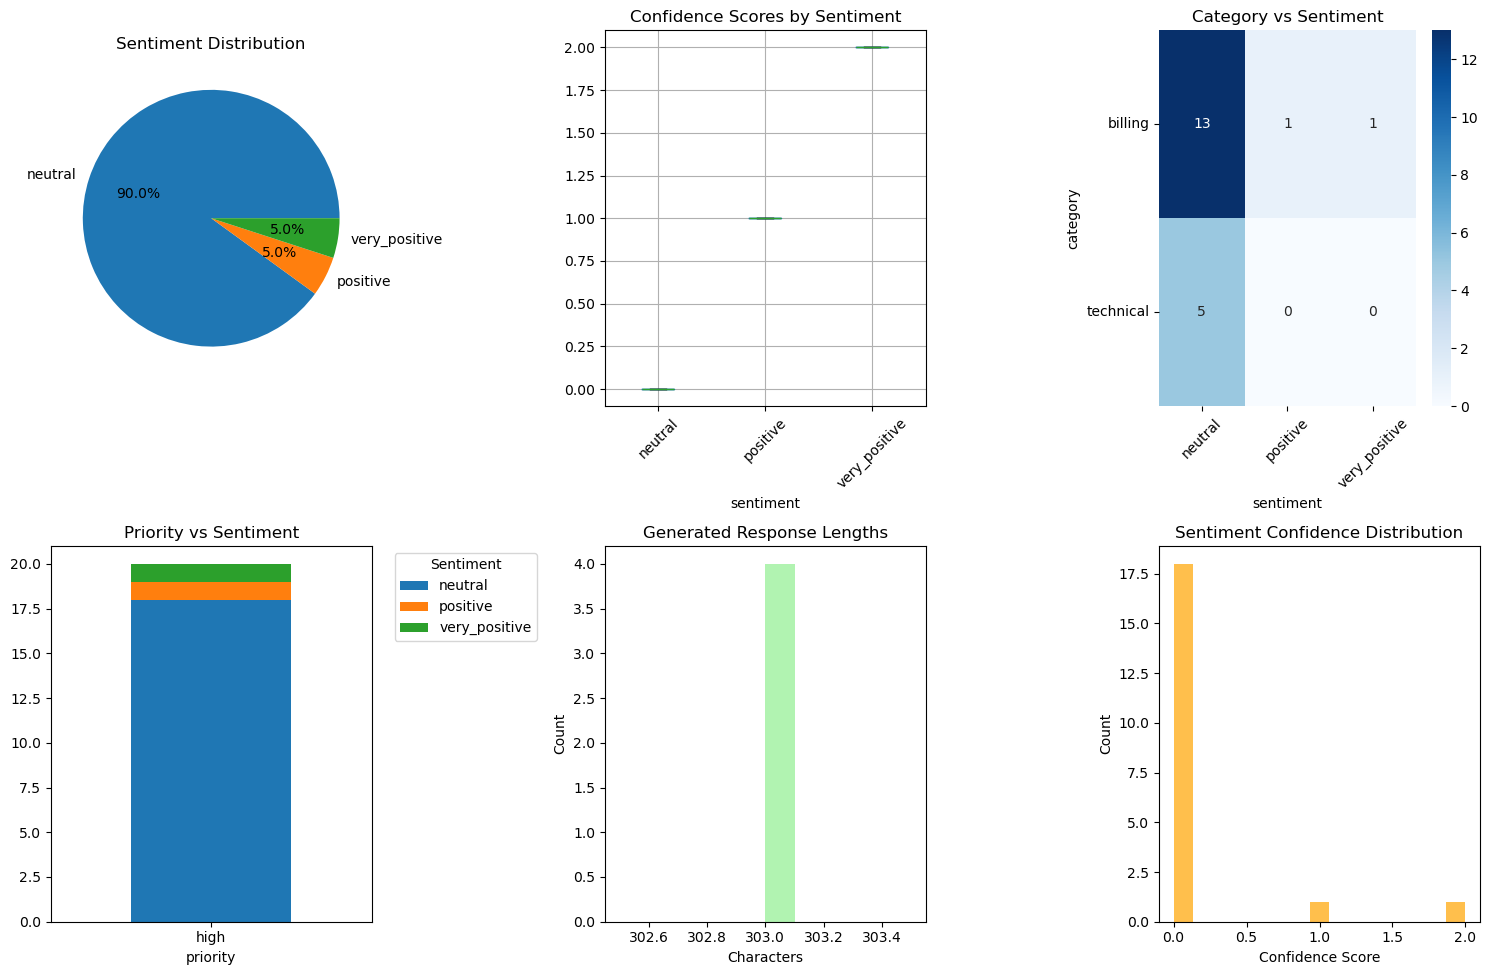

📊 Sentiment analysis charts saved to ../outputs/sentiment_analysis.png


In [8]:
# Create sentiment analysis visualization
plt.figure(figsize=(15, 10))

# Sentiment distribution
plt.subplot(2, 3, 1)
sentiment_df = pd.DataFrame([(r['detailed_sentiment']['sentiment'], 1) for r in detailed_sentiment_results], 
                          columns=['sentiment', 'count'])
sentiment_counts = sentiment_df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

# Confidence scores by sentiment
plt.subplot(2, 3, 2)
confidence_data = [(r['detailed_sentiment']['sentiment'], r['detailed_sentiment']['confidence_score']) 
                  for r in detailed_sentiment_results]
confidence_df = pd.DataFrame(confidence_data, columns=['sentiment', 'confidence'])
confidence_df.boxplot(column='confidence', by='sentiment', ax=plt.gca())
plt.title('Confidence Scores by Sentiment')
plt.suptitle('')
plt.xticks(rotation=45)

# Sentiment vs Category heatmap
plt.subplot(2, 3, 3)
category_sentiment = [(r['category'], r['detailed_sentiment']['sentiment']) for r in detailed_sentiment_results]
cs_df = pd.DataFrame(category_sentiment, columns=['category', 'sentiment'])
heatmap_data = pd.crosstab(cs_df['category'], cs_df['sentiment'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Category vs Sentiment')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Sentiment vs Priority
plt.subplot(2, 3, 4)
priority_sentiment = [(r['priority'], r['detailed_sentiment']['sentiment']) for r in detailed_sentiment_results]
ps_df = pd.DataFrame(priority_sentiment, columns=['priority', 'sentiment'])
ps_counts = pd.crosstab(ps_df['priority'], ps_df['sentiment'])
ps_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Priority vs Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Response length distribution
plt.subplot(2, 3, 5)
response_lengths = [len(r['generated_response']) for r in response_results]
plt.hist(response_lengths, bins=10, alpha=0.7, color='lightgreen')
plt.title('Generated Response Lengths')
plt.xlabel('Characters')
plt.ylabel('Count')

# Sentiment confidence histogram
plt.subplot(2, 3, 6)
all_confidences = [r['detailed_sentiment']['confidence_score'] for r in detailed_sentiment_results]
plt.hist(all_confidences, bins=15, alpha=0.7, color='orange')
plt.title('Sentiment Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('../outputs/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Sentiment analysis charts saved to ../outputs/sentiment_analysis.png")

In [9]:
# Save all results
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)

# Save detailed sentiment analysis results
sentiment_export = []
for result in detailed_sentiment_results:
    export_item = {
        'ticket_text': result['ticket_text'],
        'category': result['category'],
        'priority': result['priority'],
        'predicted_eta': result['predicted_eta'],
        'complexity': result['complexity'],
        'sentiment': result['detailed_sentiment']['sentiment'],
        'confidence_score': result['detailed_sentiment']['confidence_score'],
        'raw_sentiment_score': result['detailed_sentiment']['raw_score']
    }
    sentiment_export.append(export_item)

sentiment_df = pd.DataFrame(sentiment_export)
sentiment_df.to_csv(output_dir / 'detailed_sentiment_analysis.csv', index=False)

# Save generated responses
responses_df = pd.DataFrame(response_results)
responses_df.to_csv(output_dir / 'generated_responses.csv', index=False)

# Save summary statistics
sentiment_summary = {
    'total_tickets_analyzed': len(detailed_sentiment_results),
    'responses_generated': len(response_results),
    'sentiment_distribution': dict(sentiment_df['sentiment'].value_counts()),
    'avg_confidence_score': float(sentiment_df['confidence_score'].mean()),
    'sentiment_by_category': sentiment_df.groupby('category')['sentiment'].apply(lambda x: x.mode().iloc[0] if not x.empty else 'neutral').to_dict(),
    'avg_response_length': float(np.mean([len(r['generated_response']) for r in response_results])),
    'processing_system': 'LLaMA-powered advanced sentiment analysis'
}

with open(output_dir / 'sentiment_response_summary.json', 'w') as f:
    json.dump(sentiment_summary, f, indent=2)

print("💾 Results saved:")
print(f"- Detailed sentiment analysis: {output_dir}/detailed_sentiment_analysis.csv")
print(f"- Generated responses: {output_dir}/generated_responses.csv")
print(f"- Summary statistics: {output_dir}/sentiment_response_summary.json")
print(f"- Analysis charts: {output_dir}/sentiment_analysis.png")

print("\n🎯 Key Achievements:")
print(f"- Analyzed sentiment for {sentiment_summary['total_tickets_analyzed']} tickets")
print(f"- Generated {sentiment_summary['responses_generated']} personalized responses")
print(f"- Average sentiment confidence: {sentiment_summary['avg_confidence_score']:.2f}")
print(f"- Average response length: {sentiment_summary['avg_response_length']:.0f} characters")

print("\n🎉 Sentiment Analysis & Response Generation Complete!")
print("Ready to proceed to notebook 06 (End-to-End Pipeline)")

# Clean up memory
del response_generator.model
del response_generator.tokenizer
import gc
gc.collect()
print("🧹 Memory cleaned up")

TypeError: Object of type int64 is not JSON serializable